In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk import PunktSentenceTokenizer
import matplotlib.pyplot as plt
# nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/chamod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stop_words = set(stopwords.words('english'))
stop_words.add('.')
stop_words.add(',')

tokenizer = PunktSentenceTokenizer()
def pos_tag(sentence):
    res_tokens = []
    tokens_temp = tokenizer.tokenize(sentence)
    tokens = []
    for t in tokens_temp :
        words = nltk.word_tokenize(t)
        tagged = nltk.pos_tag(words)
        tagged = [t for t in tagged if t[0] not in stop_words]
        tokens += tagged
    return tokens

def getSentences(file_name) :
    sentences = []
    long_sentences = []
    with open(file_name) as f :
        reviews = json.load(f)['Reviews']['Review']
        for d in reviews:
            for s in d["sentences"]['sentence']:
                aspect_terms = []
                if "Opinions" in s :
                    opinions = s['Opinions']['Opinion']
                    if isinstance(opinions, list) :
                        for o in opinions :
                            aspect_terms.append(o['@target'].split(" "))
                    else :
                        aspect_terms.append(opinions['@target'].split(" "))
                        
                    pos_tagged = pos_tag(s['text'])
                    tagged = []
                    for t in pos_tagged:
                        hasAspect = False
#                         if t[1] == 'NN' or t[1] == 'NNP' or t[1] == 'NNPS' or t[1] == 'NNS':
                        for aspects in aspect_terms :
                            if t[0] in aspects:
                                tagged.append((t[0], t[1], 1))
                                hasAspect = True
                                break
                        if not hasAspect :
                            tagged.append((t[0], t[1], 0))
                                
                    sentences.append(tagged)
                    long_sentences.append(s['text'])
#                     print(tagged)
#                     print(s)
#                     print(aspect_terms)
#                     print('')
    return sentences, long_sentences

train_sentences, long_sentences = getSentences('Data/ABSA-15_Restaurants_Train.json')

with open('train_sentences.pkl', 'wb') as f:
    pickle.dump(train_sentences, f)

with open('train_sentences.pkl', 'rb') as f:
    train_sentences = pickle.load(f)

print(train_sentences[8])

[(u'The', 'DT', 0), (u'duck', 'NN', 1), (u'confit', 'NN', 1), (u'always', 'RB', 0), (u'amazing', 'JJ', 0), (u'foie', 'NN', 1), (u'gras', 'NNS', 1), (u'terrine', 'VBP', 1), (u'figs', 'NNS', 1), (u'world', 'NN', 0)]


In [3]:
# nltk.download('tagsets')
# nltk.help.upenn_tagset()

In [4]:
# print(len(train_sentences))
# temp_sentences = []
# for s in train_sentences:
#     suit = False
#     for w in s:
#         if w[2] == 1:
#             suit = True
#             break
#     if suit : temp_sentences.append(s)

# train_sentences = temp_sentences
# print(len(train_sentences))

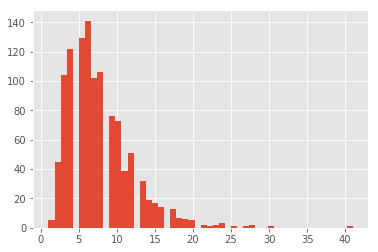

In [5]:
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [6]:
maxx = 0
for s in train_sentences:
    c = 0
    for w in s:
        if w[2]: c += 1
    if c > maxx: maxx = c

print(maxx)

14


In [7]:
word_set = set()

for s in train_sentences:
    for t in s:
        word_set.add(t[0])

words = list(word_set)
words.append("ENDPAD")

n_words = len(words); n_words

2559

In [8]:
max_len = 35
word2idx = {w: i+1 for i, w in enumerate(words)}

# word2idx
# words


In [9]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in train_sentences]

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [11]:
X[1]

array([ 996,    4, 1027, 1772, 1189,  295,  893, 1723,  295, 2274, 1707,
       1817, 1024, 1439,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [12]:
y = [[w[2] for w in s] for s in train_sentences]

In [13]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

In [14]:
y[1]
X.shape

(1120, 35)

In [15]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=False)

# X_tr = X_tr.reshape(X_tr.shape[0], 1, X_tr.shape[1])

# y_tr = y_tr.reshape(y_tr.shape[0], 1, y_tr.shape[1])

X_tr[0]

array([ 570,  494,  679,  203, 1091,  893,  634,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [16]:
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=35, activation="sigmoid")`
  from ipykernel import kernelapp as app


Train on 907 samples, validate on 101 samples
Epoch 1/50
907/907 [==============================] - 6s 7ms/step - loss: 0.3107 - acc: 0.9415 - f1: 0.0199 - precision: 0.0398 - recall: 0.0361 - val_loss: 0.1208 - val_acc: 0.9638 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
907/907 [==============================] - 2s 2ms/step - loss: 0.1242 - acc: 0.9584 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1083 - val_acc: 0.9638 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
907/907 [==============================] - 2s 2ms/step - loss: 0.1172 - acc: 0.9584 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1047 - val_acc: 0.9638 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
907/907 [==============================] - 2s 2ms/step - loss: 0.1124 - acc: 0.9584 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val

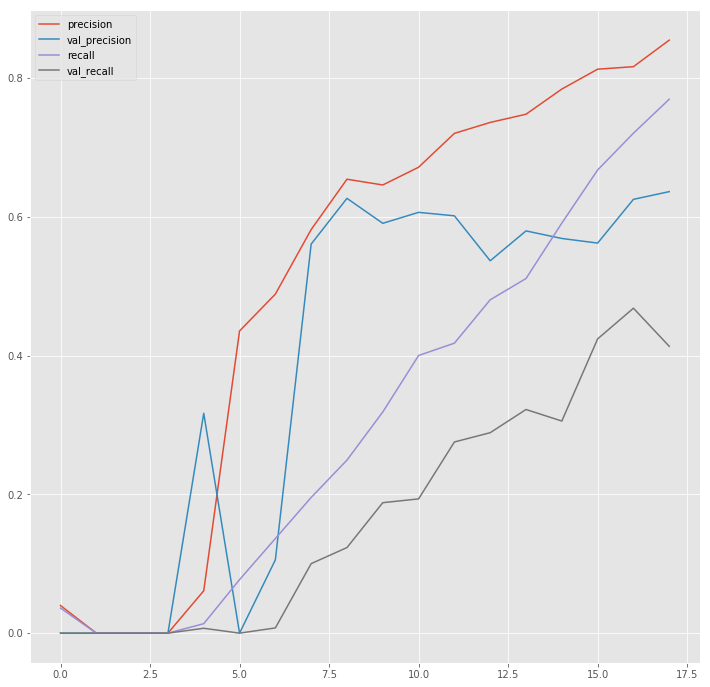

In [31]:
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
from keras.callbacks import EarlyStopping
from keras_contrib.layers import CRF

earlyStopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=max_len, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(units=max_len, return_sequences=True, recurrent_dropout=0.1)))
model.add(Flatten())
model.add(Dense(activation='sigmoid', output_dim=max_len))


# # model = Model(inputt, out)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", f1, precision, recall])

history = model.fit(X_tr, y_tr, batch_size=32, epochs=50, validation_split=0.1, verbose=1, callbacks=[earlyStopper])

hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
# plt.plot(hist["acc"] , label='acc')
# plt.plot(hist["val_acc"] , label='val_acc')

# plt.plot(hist['loss'], label='loss')
# plt.plot(hist['val_loss'], label='val_loss')
plt.plot(hist['precision'], label='precision')
plt.plot(hist['val_precision'], label='val_precision')
plt.plot(hist['recall'], label='recall')
plt.plot(hist['val_recall'], label='val_recall')
plt.legend()
plt.show()

# hist

# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score

threshold = 0.5

pred_y_te = model.predict(X_te)
# pred_y_te = np.round(pred_y_te)
pred_y_te = np.array([ [0 if e < threshold else 1 for e in p] for p in pred_y_te ])

pred_y_te[0]

print('Precision : ' + str(precision_score(y_te, pred_y_te, average='micro')))
print('Recall : ' + str(recall_score(y_te, pred_y_te, average='micro')))
print('F1-score : ' + str(f1_score(y_te, pred_y_te, average='micro')))


Precision : 0.6788990825688074
Recall : 0.39572192513368987
F1-score : 0.5


[(u'good', 'JJ', 0), (u'music', 'NN', 1), (u'great', 'JJ', 0), (u'food', 'NN', 1), (u'speedy', 'NN', 0), (u'service', 'NN', 1), (u'affordable', 'JJ', 0), (u'prices', 'NNS', 0)]
good music, great food, speedy service affordable prices.


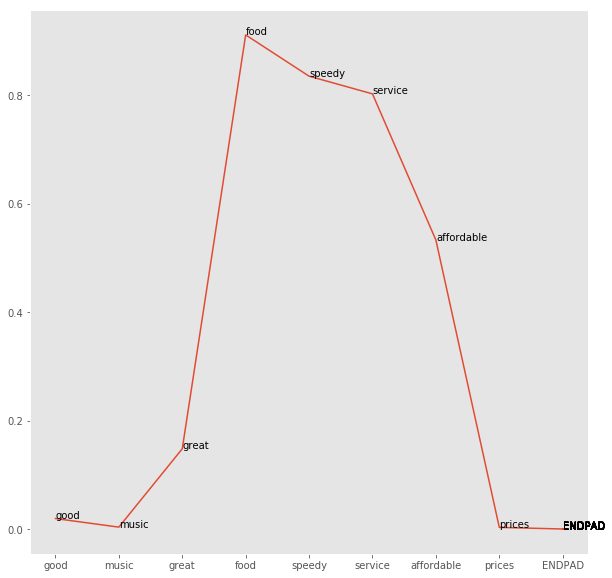

In [33]:
i = 45  #45 54 5 65
p = model.predict(np.array([X_te[i]]))
# p = np.argmax(p, axis=-1)

words_p = [words[w - 1] for w in X_te[i]]


print(train_sentences[len(X_tr) + i])
print(long_sentences[len(X_tr) + i])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plt.plot(words_p, p[0])
for xy in zip(words_p, p[0]):                                       
    ax.annotate('%s' % xy[0], xy=xy, textcoords='data')

plt.grid()
plt.show()

# p.max()
# X_te[i][10]
# print(words[X_te[i][p[0]]])

# print("{:15} ({:5})".format("Word", "True"))

# j = 0
# for w in X_tr[i]:
#     if j == p[0]:
#         print("{:15} {:5}").format(words[w], 1)
#     else :
#         print("{:15} {:5}").format(words[w], 0)
#     j += 1
# for w, pred in zip(X_te[i], p[0]):
#     print("{:15}: {}".format(words[w], tags[pred]))